<a href="https://colab.research.google.com/github/dantrainor9/food_sales_predictions/blob/main/Food_Sales_Predictions_Final3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

filename = '/content/drive/MyDrive/CodingDojo Data Science Bootcamp/01 Week 1 Foundations of Python/sales_predictions.csv'
df = pd.read_csv(filename)

Mounted at /content/drive


In [4]:
df.shape

(8523, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
df.duplicated().any()

False

In [7]:
df.isna().any()

Item_Identifier              False
Item_Weight                   True
Item_Fat_Content             False
Item_Visibility              False
Item_Type                    False
Item_MRP                     False
Outlet_Identifier            False
Outlet_Establishment_Year    False
Outlet_Size                   True
Outlet_Location_Type         False
Outlet_Type                  False
Item_Outlet_Sales            False
dtype: bool

In [8]:
df['Item_Fat_Content'].replace(['LF', 'low fat'], 'Low Fat', inplace=True)
df['Item_Fat_Content'].replace(['regular', 'reg'], 'Regular', inplace=True)
df['Outlet_Size'].replace('High', 'Large', inplace=True)
#normalizing data labels

In [9]:
df['Item_Fat_Content'].replace({'Low Fat':0, 'Regular':1}, inplace=True)
df['Outlet_Size'].replace({'Small':0, 'Medium':1, 'Large':2}, inplace=True)
df
#encoding ordinal variables before split so they stay in the correct order

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,0,0.016047,Dairy,249.8092,OUT049,1999,1.0,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,1,0.019278,Soft Drinks,48.2692,OUT018,2009,1.0,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,0,0.016760,Meat,141.6180,OUT049,1999,1.0,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,1,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,0,0.000000,Household,53.8614,OUT013,1987,2.0,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,0,0.056783,Snack Foods,214.5218,OUT013,1987,2.0,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,1,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,0,0.035186,Health and Hygiene,85.1224,OUT035,2004,0.0,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,1,0.145221,Snack Foods,103.1332,OUT018,2009,1.0,Tier 3,Supermarket Type2,1845.5976


In [10]:
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [11]:
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [12]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [13]:
df['Outlet_Location_Type'].replace({'Tier 1':0, 'Tier 2':1, 'Tier 3':2}, inplace=True)
df['Outlet_Type'].replace({'Grocery Store':0, 'Supermarket Type1':1, 'Supermarket Type2':2, 'Supermarket Type3':3}, inplace=True)
#encoding ordinal variables

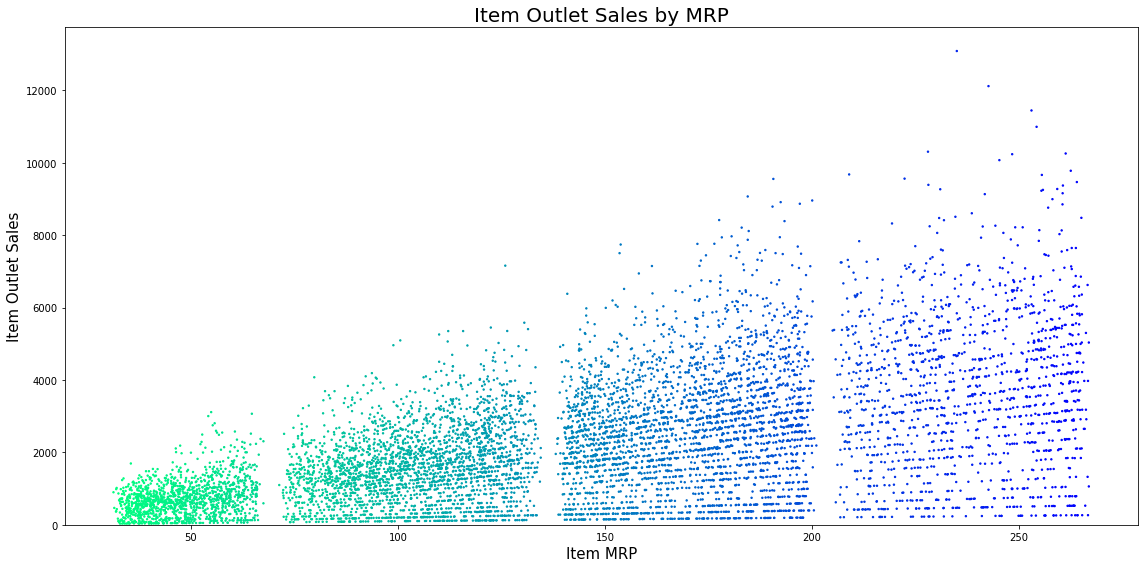

In [14]:
plt.figure(figsize=(16,8))
x = df['Item_MRP']
y = df['Item_Outlet_Sales']
plt.scatter(x=df['Item_MRP'], y=df['Item_Outlet_Sales'], s=2, c=x, cmap=plt.cm.winter_r)
plt.title('Item Outlet Sales by MRP', fontsize=20)
plt.xlabel('Item MRP', fontsize=15)
plt.ylabel('Item Outlet Sales', fontsize=15)
plt.ylim(bottom=0)
plt.tight_layout()
plt.savefig('FoodSalesvMRP.png', dpi = 300);
#looking at how MRP predictions correlate to Item Sales
#this plot makes these natural little bins
#I will separate these out next

In [15]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [16]:
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [17]:
mean_tuple = (mean_imputer, num_selector)
freq_tuple = (freq_imputer, cat_selector)
ohe_tuple = (encoder, cat_selector)
cat_pipe = make_pipeline(freq_imputer, encoder)
cat_tuple = (cat_pipe, cat_selector)
column_transformer = make_column_transformer(cat_tuple, mean_tuple)
#building column transformer for imputation

In [18]:
df2 = df.drop(columns=['Outlet_Identifier', 'Item_Identifier'])
#making a dataset for visualization

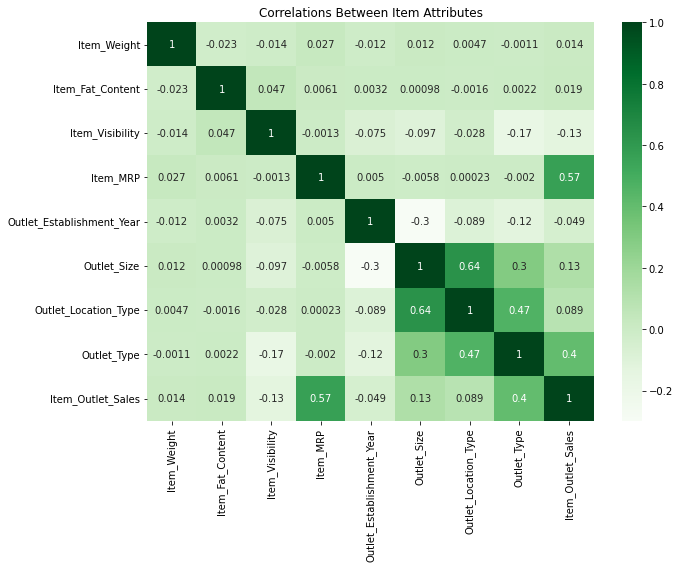

In [19]:
corr2 = df2.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr2, cmap = 'Greens', annot=True)
plt.title('Correlations Between Item Attributes')
plt.tight_layout()
plt.savefig('FoodSalesHM.png', dpi = 300);

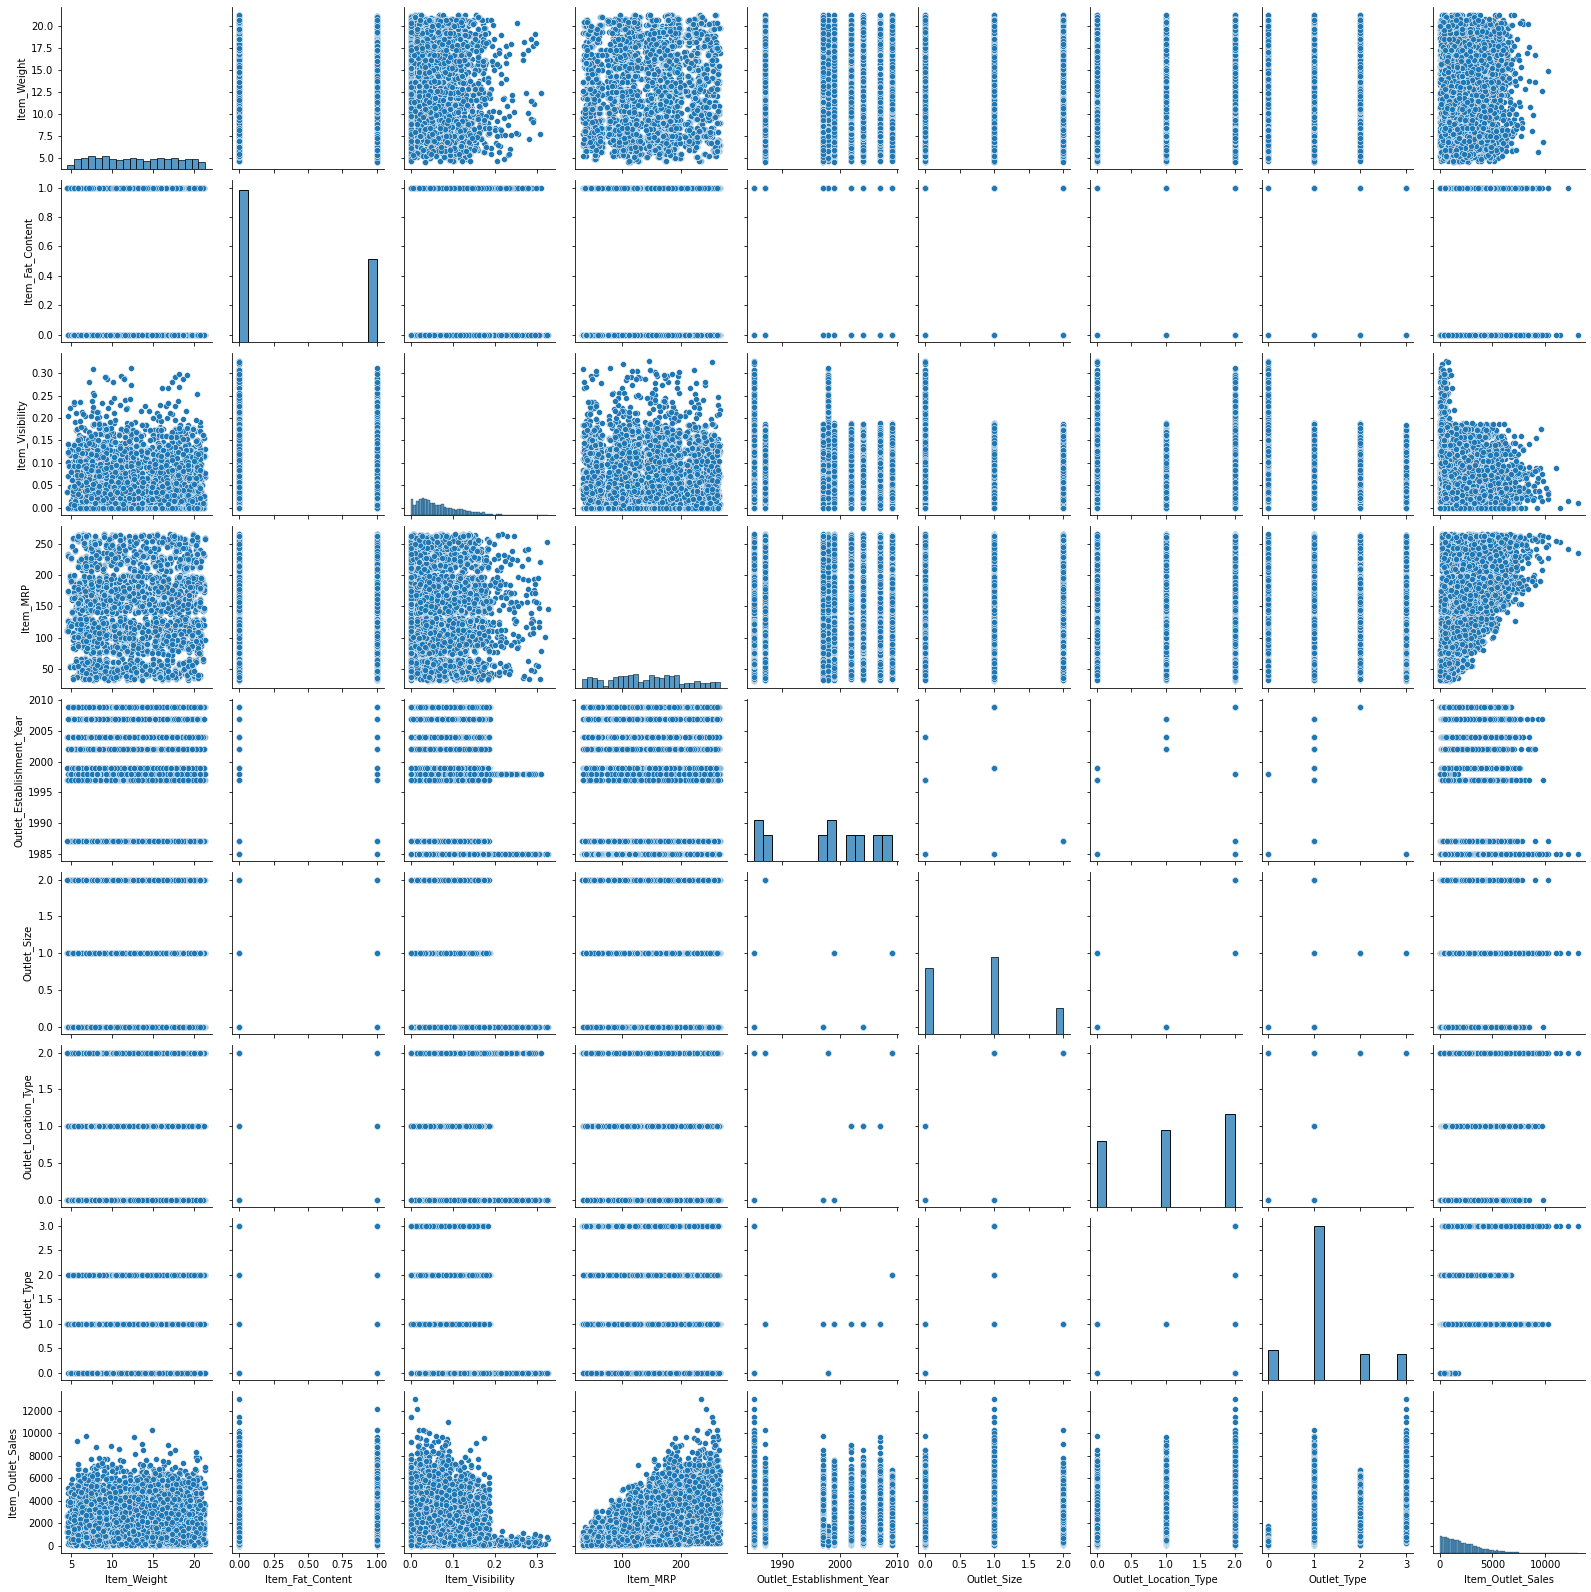

In [20]:
sns.pairplot(data=df2);

In [ ]:
#dropping some extra unnecessary columns here
X = df.drop(columns=['Item_Outlet_Sales', 'Outlet_Identifier', 'Item_Identifier'])
y = df['Item_Outlet_Sales']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
reg = LinearRegression()
pipe = make_pipeline(column_transformer, reg)
#instantiating a linear regression model

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ace764590>),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ace7646d0>)])),
         

In [ ]:
def eval_model(pipe2, X_train, y_train):
    yhattrain = pipe2.predict(X_train)
    mse_train = mean_squared_error(y_train, yhattrain)
    rmse_train = np.sqrt(mse_train)
    r2_train = pipe2.score(X_train, y_train)
    print('RMSE: ', rmse_train)
    print('r2: ', r2_train)
#making a model evaluation function

In [ ]:
eval_model(pipe, X_train, y_train)
eval_model(pipe, X_test, y_test)

RMSE:  1208.7846965744125
r2:  0.5062739271827539
RMSE:  1168.3613591069504
r2:  0.5052267115473614


In [ ]:
tree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=37, random_state=42)
#instantiating a decision tree

In [ ]:
tree_pipe = make_pipeline(column_transformer, tree)

In [ ]:
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ace764590>),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ace7646d0>)])),
         

In [ ]:
eval_model(tree_pipe, X_train, y_train)
eval_model(tree_pipe, X_test, y_test)

RMSE:  1082.9941836826476
r2:  0.6036850965207888
RMSE:  1055.7570173549782
r2:  0.5960014297252921


In [ ]:
xgb = XGBRegressor(objective='reg:squarederror')

In [ ]:
xgb_pipe = make_pipeline(column_transformer, xgb)

In [ ]:
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ace764590>),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ace7646d0>)])),
         

In [ ]:
eval_model(xgb_pipe, X_train, y_train)
eval_model(xgb_pipe, X_test, y_test)

RMSE:  1043.1880634049987
r2:  0.6322832830489132
RMSE:  1052.4224598132778
r2:  0.5985494194481209


In [ ]:
xgb_pipe.get_params()

{'columntransformer': ColumnTransformer(transformers=[('pipeline',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('onehotencoder',
                                                   OneHotEncoder(handle_unknown='ignore',
                                                                 sparse=False))]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ace764590>),
                                 ('simpleimputer', SimpleImputer(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ace7646d0>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__pipeline': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unk

In [ ]:
xgb_params = {'xgbregressor__n_estimators':[50,100,200,300],
          'xgbregressor__max_depth':[2,3,5,7,10],
          'xgbregressor__min_child_weight':[1,3,5,7,10],
          'xgbregressor__learning_rate':[0.1,0.125,0.135,0.15]}

In [ ]:
xgb_grid = GridSearchCV(xgb_pipe,xgb_params)

In [ ]:
xgb_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ace764590>),
                                                                        ('simpleimputer',
        

In [ ]:
print(xgb_grid.best_params_)

{'xgbregressor__learning_rate': 0.125, 'xgbregressor__max_depth': 3, 'xgbregressor__min_child_weight': 1, 'xgbregressor__n_estimators': 50}


In [ ]:
best_xgb = XGBRegressor(learning_rate=0.125,
                        max_depth=3,
                        min_child_weight_=1,
                        n_estimators=50)

In [ ]:
best_xgb_pipe = make_pipeline(column_transformer, best_xgb)

In [ ]:
best_xgb_pipe.fit(X_train, y_train)

[18:31:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ace764590>),
                                                 ('simpleimputer',
                                                  SimpleImputer(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0ace7646d0>)])),
         

In [ ]:
eval_model(best_xgb_pipe,X_train,y_train)
eval_model(best_xgb_pipe,X_test,y_test)

RMSE:  1055.0303283957712
r2:  0.6238872600348799
RMSE:  1048.2607968823563
r2:  0.601718106511126


Slightly better, but I want to see if another model type may outperform a tree-based model. I'll try a neural network next

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

In [ ]:
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

In [ ]:
model = Sequential()

In [ ]:
X_train_scaled.shape

(6392, 24)

In [ ]:
input_shape = X_train_scaled.shape[1]

In [ ]:
model.add(Dense(25,
                activation='relu',
                input_dim=input_shape))

model.add(Dense(10,
                activation='relu'))

model.add(Dense(5,
                activation='relu'))

model.add(Dense(3,
                activation='relu'))

model.add(Dense(1,
                activation='linear'))

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics='acc')

In [ ]:
history = model.fit(X_train_scaled, y_train,
                    validation_data = (X_test_scaled, y_test),
                    epochs=100)

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 7719615.5000 - acc: 0.0000e+00 - val_loss: 6621837.5000 - val_acc: 0.0000e+00
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 5046229.5000 - acc: 0.0000e+00 - val_loss: 2138090.0000 - val_acc: 0.0000e+00
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 1786643.7500 - acc: 0.0000e+00 - val_loss: 1522096.0000 - val_acc: 0.0000e+00
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 1548900.5000 - acc: 0.0000e+00 - val_loss: 1434404.2500 - val_acc: 0.0000e+00
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 1486002.1250 - acc: 0.0000e+00 - val_loss: 1387398.7500 - val_acc: 0.0000e+00
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 1455156.3750 - acc: 0.0000e+00 - val_loss: 1367811.6250 - val_acc: 0.0000e+00
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 1435166

A few iterations of the neural network didn't work any better than the best parameters of the XGBRegressor, so I'll go back to working on tuning those hyperparameters